## SAMPLE CLASS
_Represent a sample from a dataset_

In [108]:
import sys
import os
import numpy as np
import pandas as pd
import datetime
from math import ceil, sqrt, floor
from scipy import signal, stats
from sklearn import preprocessing
from PIL import Image
import matplotlib.pyplot as plt

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset





class Sample(Dataset):
    ''''''
    # Attributes
    __freq, __time, __spec = None, None, None
    __output = None
    __img = None
    
    # spectrogram default parameters
    __NPERSEG = 256        # Length of each segment. Defaults to None, but if window is str or tuple, is set to 256, 
                            # and if window is array_like, is set to the length of the window.
    __NOVERLAP = 64        # Number of points to overlap between segments. If None, noverlap = nperseg // 8. Defaults to None.
    __NFFT = 512           # Length of the FFT used, if a zero padded FFT is desired. If None, the FFT length is nperseg. Defaults to None.
    __DETREND = 'constant'      # Specifies how to detrend each segment. If detrend is a string, it is passed as the type argument to 
                            # the detrend function. If it is a function, it takes a segment and returns a detrended segment. 
                            # If detrend is False, no detrending is done. Defaults to ‘constant’ [‘linear’, ‘constant’]
    __SCALING = 'spectrum' # Selects between computing the power spectral density (‘density’) where Sxx has units of V**2/Hz and 
                            # computing the power spectrum (‘spectrum’) where Sxx has units of V**2, if x is measured in V and fs is measured in Hz. Defaults to ‘density’.
    __MODE = 'magnitude'         # Defines what kind of return values are expected. Options are [‘psd’, ‘complex’, ‘magnitude’, ‘angle’, ‘phase’]. 
                            # ‘complex’ is equivalent to the output of stft with no padding or boundary extension. 
                            # ‘magnitude’ returns the absolute magnitude of the STFT. 
                            # ‘angle’ and ‘phase’ return the complex angle of the STFT, with and without unwrapping, respectively.

    
    # Initializer
    def __init__(self, dataset_location, site, file):
        self.__file = file
#         super(Sample, self).__init__(dataset_location, site)
        super().__init__(dataset_location, site)
    #
    def get_file(self):
        return self.__file
    
    
    # SPECTROGRAM DATA EXTRACTION
    def frread(self):
        """ This is a rough translation of frread.m from J. Lichtenberger for the
        stereo=True case, i.e. we assume orthogonal loop antenna.
        inputs
            fname (string): File name path to the .vr2 file to load
        outputs
            wh (ndarray): 2xN array with the two traces in the first and second rows.
        """
        # open file for reading
        fid = open(os.path.join(self.get_dataset_location(), self.get_site(), self.get_site()+'_data', self.__file), 'rb')
        # get data from file - 16-bit signed integers
        dat = np.fromfile(fid, dtype=np.int16)
        # length of one frame
        frLen = 4103  ## not sure how this is determined
        # number of frames to read
        nFrameRead = len(dat) / frLen
        # data length of frame
        adatlen = 2048
        # length of data set
        N = int(nFrameRead * adatlen)
        wh = np.zeros((N, 2), dtype=float)
        # for every frame
        for i in np.arange(0, nFrameRead, dtype=int):
            # indices for first component
            i1 = np.arange(7 + i * frLen, (i + 1) * frLen, 2, dtype=int)
            # indices for second component
            i2 = np.arange(8 + i * frLen, (i + 1) * frLen + 0, 2, dtype=int)
            ii = np.arange(i * adatlen, (i + 1) * adatlen, dtype=int)
            wh[ii, 0] = dat[i1]
            wh[ii, 1] = dat[i2]
        return wh
    
    def vr2_to_panda(self):
        """Extract the data from a file a store it as a Panda DataFrame
        inputs
            fname    file name
            site     name of the site where data was collected
        outputs 
            whdf     dataframe containing the signal received by the NS and EW pointitng
                        orthogonal loop antennas
            fs       sampling frequency
        """
        # read vr2 file
        wh = self.frread()

        # CONSTANTS
        # Sampling frequency (20kHz for SANAE, 40kHz for MARION )
        if self.get_site()=='marion':
            fs = 4e4
        elif self.get_site()=='sanae':
            fs = 2e4
        else:
            fs = 4e4
        # time step in microseconds (for dataframe index)
        dt = 1e6 / fs

        # Set the date/time format in the filename
        # dtFormat = '%Y-%m-%dUT%H_%M_%S.%f'
        dtFormat = '%Y-%m-%dUT%H:%M:%S.%f'

        # Set up pandas dataframe
        # Start time
        t0 = pd.datetime.strptime(self.__file[0:27], dtFormat)
        # Number of samples
        Nsamples = len(wh[:, 0])
        # End time
        t1 = t0 + datetime.timedelta(0, 0, Nsamples * dt)
        # Create index
        tindex = pd.date_range(start=t0, periods=Nsamples, freq='50U') # freq = 50us

        # Create pandas data frame from wh
        whdf = pd.DataFrame(index=tindex, data=wh[:, 0], columns=['X'])
        whdf['Y'] = wh[:, 1]
        # The 'X' and 'Y' columns are the signal received by the North/South and
        # East/West pointing orthogonal loop antennas used at Marion and SANAE

        return whdf, fs
    
    def set_spectrogram_params(self, nperseg = __NPERSEG, noverlap = __NOVERLAP,
                            nfft = __NFFT, 
                            detrend = __DETREND,
                            scaling = __SCALING,
                            mode = __MODE):
        '''Always call assert_spectrogram after this function to recompute  self.__spec'''
        self.__NPERSEG = nperseg
        self.__NOVERLAP = noverlap
        self.__NFFT = nfft
        self.__DETREND = detrend
        self.__SCALING = scaling
        self.__MODE = mode
    
    def get_spectrogram_params(self):
        params = {
            'nperseg': self.__NPERSEG, 
            'noverlap': self.__NOVERLAP,
            'nfft': self.__NFFT, 
            'detrend': self.__DETREND,
            'scaling': self.__SCALING,
            'mode': self.__MODE
        }
        return params
    
    def get_spectrogram(self):
        return self.__spec
    
    def get_image(self):
        return self.__img
    
    def spectrogram(self, nperseg = __NPERSEG, noverlap = __NOVERLAP,
                            nfft = __NFFT, 
                            detrend = __DETREND,
                            scaling = __SCALING,
                            mode = __MODE, log10 = True, abs_val = False):
        """Compute spectrogram from vr2 data collected
        outputs
            frequencies, time, and spectrum of the sprectrogram
        """
        whdf, fs = self.vr2_to_panda()
        self.__freq, self.__time, self.__spec = signal.spectrogram(
            whdf.X.values, 
            fs=fs, 
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft, 
            detrend=detrend, 
            scaling=scaling,
            mode=mode)
        if log10:
            self.__spec = np.log10(self.__spec)
        if abs_val:
            self.__spec = abs(self.__spec)
        return self.__spec
    
    def spectrogram_with_axis(self, nperseg = __NPERSEG, noverlap = __NOVERLAP,
                            nfft = __NFFT, 
                            detrend = __DETREND,
                            scaling = __SCALING,
                            mode = __MODE, log10 = True, kHz = True, abs_val = False):
        """Compute spectrogram from vr2 data collected
        outputs
            frequencies, time, and spectrum of the sprectrogram
        """
        whdf, fs = self.vr2_to_panda()
        self.__freq, self.__time, self.__spec = signal.spectrogram(
            whdf.X.values, 
            fs=fs, 
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft, 
            detrend=detrend, 
            scaling=scaling,
            mode=mode)
        if kHz:
            self.__freq /= 1e3
        if log10:
            self.__spec = np.log10(self.__spec)
        if abs_val:
            self.__spec = abs(self.__spec)
        return self.__freq, self.__time, self.__spec
    
    def assert_spectrogram(self, force=False, log10=True, kHz=True, abs_val = False):
        '''Compute __spec if None'''
        if self.__spec is None or force:
            self.spectrogram_with_axis(nperseg = self.__NPERSEG, 
                                        noverlap = self.__NOVERLAP,
                                        nfft = self.__NFFT, 
                                        detrend = self.__DETREND,
                                        scaling = self.__SCALING,
                                        mode = self.__MODE, log10=log10, kHz=kHz,abs_val = abs_val)
    
    def spectrogram_plot(self, spec=None, figsize=None, xaxis=False, yaxis=False, xlabel=None, ylabel=None, title=None, cmap='jet' ):
        self.assert_spectrogram()
        if spec is None:
            spec = np.copy(self.__spec)
        
        if figsize:
            fig = plt.figure(figsize=figsize)
        else:
            fig = plt.figure()
        if xaxis and yaxis:
            img = plt.pcolormesh(self.__time, self.__freq, spec, cmap=cmap)
        else:
            img = plt.pcolormesh(spec, cmap=cmap)
        fig.colorbar(mappable=img, label=str(self.__SCALING))
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        if title:
            plt.title(title)
        plt.xticks(np.arange(0, spec.shape[1], 50))
        plt.yticks(np.arange(0, spec.shape[0], 10))
        plt.show()
        
    def spectrogram_hist(self, figsize=None, xlabel='Bins', ylabel='Quantity', title='Histogram'):
        '''Plot histrogram of spectrogram'''
        self.assert_spectrogram()
        if figsize:
            fig = plt.figure(figsize=figsize)
        else:
            fig = plt.figure()
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        if title:
            plt.title(title)
        plt.hist(self.__spec.flatten(), bins='auto')
        plt.show()

    # SPECTROGRAM PROCESSING 
    def apply_zscore(self):
        self.assert_spectrogram()
        self.__spec = stats.zscore(self.__spec, axis = 0)
        self.__spec = stats.zscore(self.__spec, axis = 1)
    
    def apply_medfilt(self, kernel, iteration=1):
        self.assert_spectrogram()
        for i in range(iteration):
            self.__spec = signal.medfilt2d(self.__spec, kernel)
    
    def apply_normalization(self):
        self.assert_spectrogram()
        self.__spec = preprocessing.normalize(self.__spec)
    
    def apply_shift(self, minimum=None):
        if not minimum:
            self.__spec -= self.__spec.min()
    def apply_exp(self, exp):
        self.__spec = exp**self.__spec
    
    def apply_log10(self):
        self.__spec = np.log10(self.__spec)
        
    def apply_min_max_scale(self, minimum, maximum):
        self.assert_spectrogram()
        scaler = preprocessing.MinMaxScaler(feature_range=(minimum, maximum))
        self.__spec = scaler.fit_transform(self.__spec)        
    
    def apply_threshold(self, n, _min=0, _max=None):
        mean, std = np.mean(self.__spec), np.std(self.__spec)
        width, height = self.__spec.shape
#         _min, _max = self.__spec.min(), self.__spec.max()
        self.__spec = self.__spec.reshape(width*height)
        if _max:
            self.__spec = np.array([_min if x<=mean+n*std else _max for x in self.__spec])
        else:
            self.__spec = np.array([_min if x<=mean+n*std else x+_min for x in self.__spec])
        self.__spec = self.__spec.reshape((width, height))
        
    def to_img(self):
        self.assert_spectrogram()
        spec = (self.__spec.astype(np.float64)-self.__spec.min())/(self.__spec.max()-self.__spec.min()) # normalize the data to 0 - 1
        spec = 255*spec
        spec = spec.astype(np.uint8)
        self.__img = Image.fromarray(spec, mode='L').transpose(Image.FLIP_TOP_BOTTOM)
    
    # AWDA OUTPUT
    def output(self, verbose=False):
        '''Extract the output information of a file and return the file and the file time format
            as well as the time diffence between the detection of a whistler as per AWDA and the
            begining of the data collection
            returns:
                file time format
                time difference 
        '''
        if self.get_awda_output() is None:
            output_data = self.awda_output(verbose=verbose)[self.__file]
        else:
            output_data = self.get_awda_output()[self.__file]
        file_time = self.__file[:27]
        outputs = []
        for key,value in output_data.items():
            outputs.append([round(self._datetime_diff(key,file_time),5), value])
            outputs = sorted(outputs, key=lambda x:x[0])
        self.__output = np.array(outputs)
        return file_time, output_data, self.__output
    
    def output_thresholded(self,threshold):
        if self.__output is None:
            self.output()
        '''Return the indexes when the measure of detection is above the threshold'''
        return [index for index in self.__output if int(index[-1]) >= threshold]
    
    def output_indexed(self, threshold=0, verbose=False):
        self.assert_spectrogram()
        file_time, output_data, _ = self.output(verbose=verbose)
        outputs = self.output_thresholded(threshold)
        _t = np.round_(self.__time,decimals=4)
        index = 0
        indices = []
        indexed_output = []
        for o in outputs:
            event_time = np.round(float(o[0]),4)
            # find index of that event in the spectrogram
            index = min(range(len(_t)), key=lambda i: abs(_t[i]-event_time))
            # only process if the index found is new
            if index!=0 and index not in indices:
                indices.append(index)
            indexed_output.append([index,str(list(output_data.keys())[list(output_data.values()).index(o[1])]),
                                       o[0], o[1]])
        return indexed_output
    
    def output_plot(self, threshold=0, verbose=False, figsize=None, xaxis=None, yaxis=None, xlabel=None, ylabel=None, title=None, cmap='jet'):
        self.assert_spectrogram()
        spectrogram = np.copy(self.__spec)
        # add output markers
        for index_pb in self.output_indexed(threshold, verbose):
            spectrogram[:,index_pb[0]] = np.full(spectrogram[:,index_pb[0]].shape, spectrogram.min())   
        self.spectrogram_plot(spec=spectrogram, figsize=figsize, xaxis=xaxis, yaxis=yaxis, xlabel=xlabel, ylabel=ylabel, title=title, cmap=cmap)
    
    # GENERATE SLICES
    def cuts(self, cut_time=1, cut_freq=10, threshold=0, noise=True):
        '''Extract whistler cut out of the spectrogram using the output file oubtained form the AWDA method
        params:
            cut_time: duration of the cut [second]
            cut_freq: frequency span of the cut [kHz]
        returns:
            spectrogram
            whistlers boundaries
            noise boundaries
        '''
        # define slice length
        time_min = 0.3*cut_time
        time_max = 0.7*cut_time
        freq_min = 0.0*cut_freq
        freq_max = 1.0*cut_freq
        
        self.assert_spectrogram()
        indices = self.output_indexed(threshold=threshold)
        
        time_max_index = self.__time.shape[0] # maximum index on the time axis
        freq_max_index = self.__freq.shape[0] # maximum index on the frequency axis
        time_res = self.__time[-1]/time_max_index   # time resolution
        freq_res = self.__freq[-1]/freq_max_index # frequency resolution
        
        # freqeucny cut indexes
        freq_cut_min_index, freq_cut_max_index = int(freq_min/freq_res), int(freq_max/freq_res)
        
        whistler_cuts = [] 
        for index in indices:
            # find maximum time for this location
            output_index = int(index[0])
            time_cut_min_index, time_cut_max_index = output_index, output_index
            
            if output_index + int(time_max/time_res) <= time_max_index:
                time_cut_max_index += int(time_max/time_res)
            else:
                extra = abs(time_max_index - (output_index + int(time_max/time_res)))
                time_cut_max_index = time_max_index
                time_cut_min_index -= (int(time_min/time_res)+extra)
                whistler_cuts.append([freq_cut_min_index,freq_cut_max_index,time_cut_min_index,time_cut_max_index])
                continue
            if output_index - int(time_min/time_res) >= 0:
                time_cut_min_index -= int(time_min/time_res)
            else:
                extra = abs(output_index - int(time_min/time_res))
                time_cut_max_index += extra
                time_cut_min_index = 0
            whistler_cuts.append([freq_cut_min_index,freq_cut_max_index,time_cut_min_index,time_cut_max_index])
        whistler_cuts = np.array(whistler_cuts)
        if noise:
            noise_cuts = []
            if whistler_cuts.size!=0: # don't take noise cuts from data with no whistler cuts
                # get cuts from freq_upper_boundary
                freq_cut_length = int(freq_min/freq_res)+int(freq_max/freq_res)
                time_cut_length = int(time_min/time_res)+int(time_max/time_res)
                if freq_max_index-freq_cut_max_index >= freq_cut_length:
                    for i in range(0,time_max_index,time_cut_length):
                        if time_max_index-i>=time_cut_length:
                            noise_cuts.append([freq_cut_max_index,freq_cut_max_index+freq_cut_length,i,i+time_cut_length])
            # get cuts from time_lower_boundary
            time_cut_min_index = whistler_cuts[:,2].min()
            if time_cut_min_index-time_cut_length > 0:
                for i in range(0, time_cut_min_index, time_cut_length):
                    if time_cut_min_index-i>= time_cut_length:
                        noise_cuts.append([0, freq_cut_max_index,i,i+time_cut_length])
            # get cuts from time_upper_boundary
            time_cut_max_index = whistler_cuts[:,3].max()
            if time_cut_max_index+time_cut_length <= time_max_index:
                for i in range(time_cut_max_index, time_max_index, time_cut_length):
                    if i+time_cut_length<=time_max_index:
                        noise_cuts.append([0, freq_cut_max_index,i,i+time_cut_length])

            noise_cuts = np.array(noise_cuts)
            cuts = np.append(whistler_cuts, noise_cuts, axis=0)
            return cuts, len(indices), len(cuts)
        else:
            return whistler_cuts,len(indices), len(whistler_cuts)
    
    def cut_plot(self, cut):
        spectrogram = self.__spec[cut[0]:cut[1], cut[2]:cut[3]]
        self.spectrogram_plot(spec=self.__spec[cut[0]:cut[1], cut[2]:cut[3]])
    
    def cuts_plot(self, threshold=0, cmap='jet', noise=True):
        '''Plot all cuts
        params:
            threshold: threshold for the awda figure of merit
        '''
        cuts, nbr_evt, nbr_cuts = self.cuts(threshold=threshold, noise=noise)
        x_size = ceil(sqrt(len(cuts)))
        y_size = ceil(len(cuts)/x_size)
        n = 2 # number of plot per sample
        plt.figure(figsize=(y_size*2*n, x_size*n))
        for plt_ix in range(0,len(cuts)*n, n):
            ax = plt.subplot(x_size, y_size*n, plt_ix+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            ix =int(plt_ix/n)
            cut = cuts[ix]
            plt.pcolormesh(self.__spec[cut[0]:cut[1], cut[2]:cut[3]], cmap=cmap)
            ax.set_title(str(ix)+': '+str(ix<=nbr_evt))
            ax = plt.subplot(x_size, y_size*n, plt_ix+2)
            plt.yticks([])
            plt.xticks([])
            plt.grid(False)
            ix =int(plt_ix/n)
            cut = cuts[ix]
            plt.hist(self.__spec[cut[0]:cut[1], cut[2]:cut[3]].flatten(), bins='auto')
            ax.set_title(str(ix)+': '+str(ix<=nbr_evt))
        plt.show()
        
    def split(self, width, height):
        '''Split the spectrogram according to width and height'''
        # mark the cut in the spectrogram
        spec = self.__spec.copy()
        f_max, t_max = spec.shape
        t_index = np.array(list(range(0, t_max, ceil(t_max/width))))
        f_index = np.array(list(range(0, f_max, ceil(f_max/height))))
        for t in t_index:
            spec[:,t] = np.full(spec[:,0].shape, spec.min())
        for f in f_index:
            spec[f,:] = np.full(spec[0,:].shape, spec.min())
        # extract the cuts
        cuts = []
        indices = []
        for f in range(len(f_index)):
            for t in range(len(t_index)):
                if t < len(t_index)-1 and f<len(f_index)-1:
                    cuts.append(self.__spec[f_index[f]:f_index[f+1],t_index[t]:t_index[t+1]])
                    indices.append([t_index[t],t_index[t+1],f_index[f],f_index[f+1]])
                elif f == len(f_index)-1 and t < len(t_index)-1:
                    cuts.append(self.__spec[f_index[f]:f_max,t_index[t]:t_index[t+1]])
                    indices.append([t_index[t],t_index[t+1],f_index[f],f_max])
                elif t==len(t_index)-1 and f < len(f_index)-1:
                    cuts.append(self.__spec[f_index[f]:f_index[f+1],t_index[t]:t_max])
                    indices.append([t_index[t],t_max,f_index[f],f_index[f+1]])
                else:
                    cuts.append(self.__spec[f_index[f]:f_max,t_index[t]:t_max])
                    indices.append([t_index[t],t_max,f_index[f],f_max])
        cuts = np.array(cuts)
        return spec, indices, cuts

2013-05-18UT14:02:12.39592156.marion.vr2


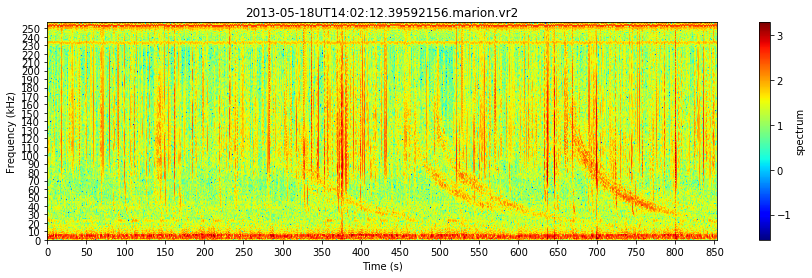

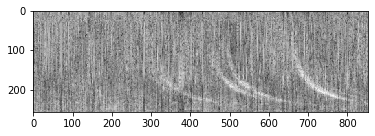

(853, 257)


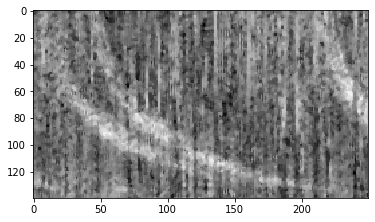

In [122]:
# import imageio

# loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(loc, site)
# my_sample = Sample(loc, site, my_dataset.get_random_sample())
# # my_sample = Sample(loc, 'marion', '2013-05-27UT00:59:39.62002156.marion.vr2')
# # my_sample = Sample(loc, 'marion', '2013-05-20UT20:15:09.24222156.marion.vr2')
# # my_sample = Sample(loc, 'marion', '2013-07-25UT15:06:06.85411922.marion.vr2')
# # my_sample = Sample(loc, 'marion', '2013-07-26UT02:35:55.34691914.marion.vr2')
# # my_sample = Sample(loc, 'marion', '2013-07-04UT19:09:19.11011930.marion.vr2')
# # my_sample = Sample(loc, 'marion', '2013-05-18UT14:02:12.39592156.marion.vr2')
# print(my_sample.get_file())
# size=(15,4)

# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())

# spec = my_sample.get_spectrogram()
# spec = spec.astype(np.float64)/spec.max() # normalize the data to 0 - 1
# print(spec.min(), spec)
# spec = 255*spec
# spec = spec.astype(np.uint8)

# my_sample.spectrogram_plot(spec=spec,figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())

# data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
# data = 255 * data # Now scale by 255
# img = data.astype(np.uint8)

# my_sample.apply_threshold(0.5)
# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())

# imageio.imwrite('spec.jpg', np.flip(my_sample.get_spectrogram(),0))

# my_sample.apply_min_max_scale(0,255)
# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
# imageio.imwrite('spec_0_255.jpg', np.flip(my_sample.get_spectrogram(),0))

# my_sample.apply_zscore()
# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
# imageio.imwrite('spec_zscore.jpg', np.flip(my_sample.get_spectrogram(),0))


# my_sample.apply_medfilt(kernel=(3,3))
# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
# imageio.imwrite('spec_zscore_medfil_(3,3).jpg', np.flip(my_sample.get_spectrogram(),0))

# my_sample.spectrogram_with_axis()
# my_sample.apply_zscore()
# my_sample.apply_medfilt(kernel=(9,9))
# my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
# imageio.imwrite('spec_zscore_medfil_(9,9).jpg', np.flip(my_sample.get_spectrogram(),0))